### Import Libraries

In [2]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

#import warnings
#warnings.simplefilter(action="ignore")

# Set all columns and rows to be displayed
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


### Import Data

In [3]:
# Import the dataset
data = pd.read_csv("../datasets/merged_df2.csv")

In [4]:
# Check the data
data.head()

,time,dengue_cases,denv_1,denv_2,denv_3,denv_4,Mean Temperature (°C),Mean Wind Speed (km/h),Daily Rainfall Total (mm),Maximum Temperature (°C),Max Wind Speed (km/h),Minimum Temperature (°C),google_trends
0,2018-04-08,38,0.000,0.505,0.484,0.011,28.528571,10.714286,0.742857,33.8,36.7,25.5,20
1,2018-04-15,56,0.000,0.505,0.484,0.011,28.914286,9.828571,2.057143,34.4,38.2,24.6,18
2,2018-04-22,55,0.000,0.505,0.484,0.011,28.142857,7.700000,0.371429,34.3,37.1,25.5,21
3,2018-04-29,74,0.000,0.505,0.484,0.011,28.414286,6.842857,4.800000,35.0,43.6,22.6,23
4,2018-05-06,62,0.029,0.549,0.382,0.039,28.785714,8.328571,3.742857,34.2,44.6,23.6,39


No catagorical values observed. However, due to the different types of numerical values being used, scaling will be required.

In [5]:
# Check the shape of the data
data.shape

(257, 13)

In [6]:
# Look at the datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   time                       257 non-null    object 
 1   dengue_cases               257 non-null    int64  
 2   denv_1                     257 non-null    float64
 3   denv_2                     257 non-null    float64
 4   denv_3                     257 non-null    float64
 5   denv_4                     257 non-null    float64
 6   Mean Temperature (°C)      257 non-null    float64
 7   Mean Wind Speed (km/h)     257 non-null    float64
 8   Daily Rainfall Total (mm)  257 non-null    float64
 9   Maximum Temperature (°C)   257 non-null    float64
 10  Max Wind Speed (km/h)      257 non-null    float64
 11  Minimum Temperature (°C)   257 non-null    float64
 12  google_trends              257 non-null    int64  
dtypes: float64(10), int64(2), object(1)
memory usage: 

### Date Processing

The date feature is currently an object time. We will be converting it into a dateTime format.

In [7]:
# Convert the date column into dateTime format
data['time'] = pd.to_datetime(data['time'])

In [8]:
# Set the time as the index
data = data.set_index('time')

In [9]:
# Check the data 
data.head()

,dengue_cases,denv_1,denv_2,denv_3,denv_4,Mean Temperature (°C),Mean Wind Speed (km/h),Daily Rainfall Total (mm),Maximum Temperature (°C),Max Wind Speed (km/h),Minimum Temperature (°C),google_trends
time,,,,,,,,,,,,
2018-04-08,38,0.000,0.505,0.484,0.011,28.528571,10.714286,0.742857,33.8,36.7,25.5,20
2018-04-15,56,0.000,0.505,0.484,0.011,28.914286,9.828571,2.057143,34.4,38.2,24.6,18
2018-04-22,55,0.000,0.505,0.484,0.011,28.142857,7.700000,0.371429,34.3,37.1,25.5,21
2018-04-29,74,0.000,0.505,0.484,0.011,28.414286,6.842857,4.800000,35.0,43.6,22.6,23
2018-05-06,62,0.029,0.549,0.382,0.039,28.785714,8.328571,3.742857,34.2,44.6,23.6,39


### Train/Test Split

In [10]:
# Train data will coveer 2018 to 2021
train = data.iloc[:195]

In [11]:
# Test data will cover 2022 to March 2023
test = data.iloc[195:]

In [12]:
train.shape

(195, 12)

In [13]:
test.shape

(62, 12)

In [14]:
62/195

0.31794871794871793

Overall, this is about a 30% train test split:
* Train: 70% of data
* Test: 30% of data

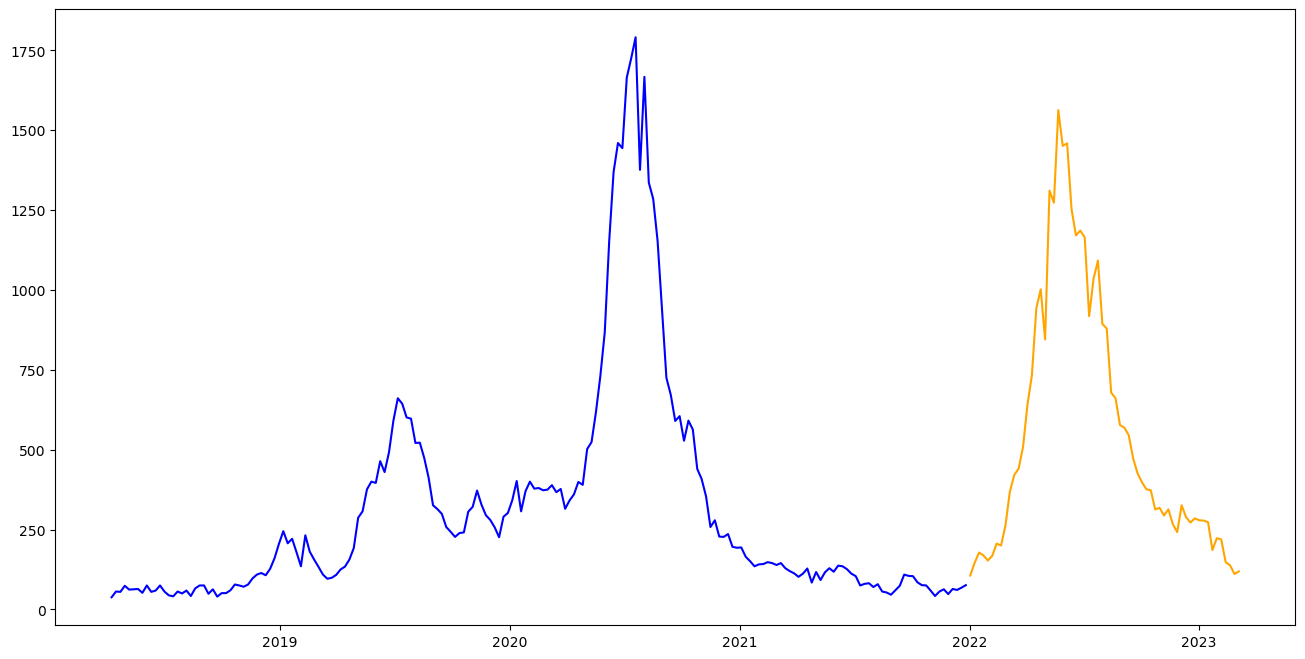

In [15]:
# Time series plot of the train and test data
def train_test_plot(train, test):
    plt.figure(figsize=(16, 8))
    plt.plot(train['dengue_cases'], c='blue')
    plt.plot(test['dengue_cases'], c='orange');
    
train_test_plot(train, test)

### Stationarity Test

We will use the stationarity test to identify the $d$ parameter for the ARIMA model

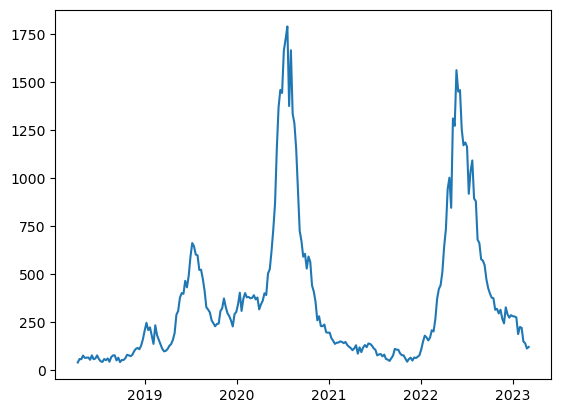

In [16]:
# Plot the data
plt.plot(data['dengue_cases']);

The time series of the dengue cases is clearly not stationary

In [17]:
# Instantiate a new dataframe for the difference information
diff = pd.DataFrame()

In [18]:
# Calculate the first difference of the dengue cases
diff['first_diff_dengue'] = data['dengue_cases'].diff()

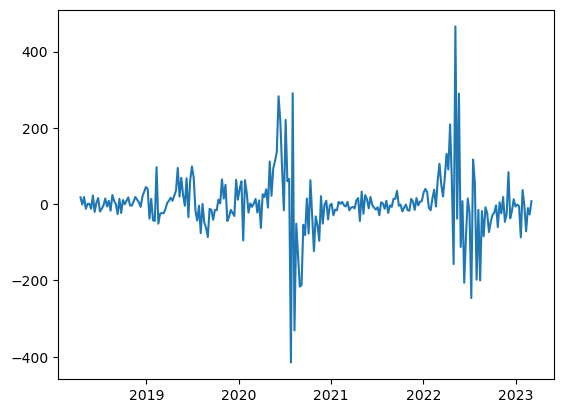

In [19]:
# Plot the first difference of the dengue cases
plt.plot(diff['first_diff_dengue']);

From the plot above, we can see that when the data is differenced once, the data is stationary. 

#### Augmented Dickey-Fuller Test

Let's also use the ADF test to test for Stationarity

In [20]:
# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [21]:
# Run the ADF test on the original dengue data
interpret_dftest(adfuller(data['dengue_cases']))

Test Statistic   -2.549748
p-value           0.103834
dtype: float64

The p-value is above 0.05, hence this data is not stationary.

In [22]:
# Run the ADF test on the differenced dengue data
interpret_dftest(adfuller(data['dengue_cases'].diff().dropna()))

Test Statistic   -5.242290
p-value           0.000007
dtype: float64

The p-value is below 0.05 and we can conclude that the once differenced data is stationary. This is also in line with the differenced data plot. Hence, we can set the $d$ value to $1$.

### Finding the $p$ and $q$ values

We can use a ACF and PACF plot to find the $p$ and $q$ values.

#### ACF and PACF Plot for $p$ value

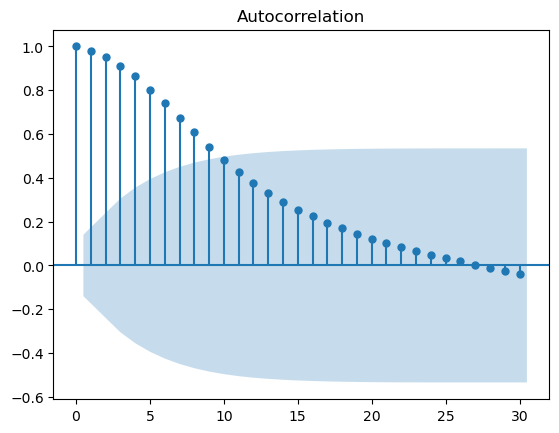

In [23]:
# Generate autocorrelation plot on training data.
plot_acf(train['dengue_cases'], lags = 30);

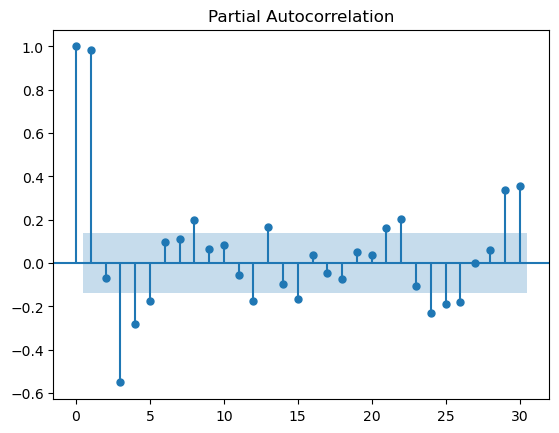

In [24]:
# Generate partial autocorrelation plot on training data.
plot_pacf(train['dengue_cases'], lags = 30);

The first lag of the ACF plot is also positive. There is also a sharp cut off in the PACF plot after the second lag. Hence, we can take the next lag of the PACF as the $p$ value and set it to $3$. 

As the $AR$ and $MA$ terms might work against each other and we were able to identify the $p$ value, we will set the $q$ value as $0$.  

### ARIMA Model (3, 1, 0)

Next, we can fit the ARIMA model and run the prediction.

In [25]:
# Instantiate best model.
arima = ARIMA(endog=train['dengue_cases'], order=(3, 1, 0))

# Fit ARIMA model.
model = arima.fit()

# Generate predictions based on test set.
#preds = model.predict(start=test.index[0], end = test.index[-1])
# Start at 196 instead of 195 because we took difference = 1
preds = model.predict(start=196, end=257)

/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:574: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  is_monotonic = index.is_monotonic if date_index else None
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN

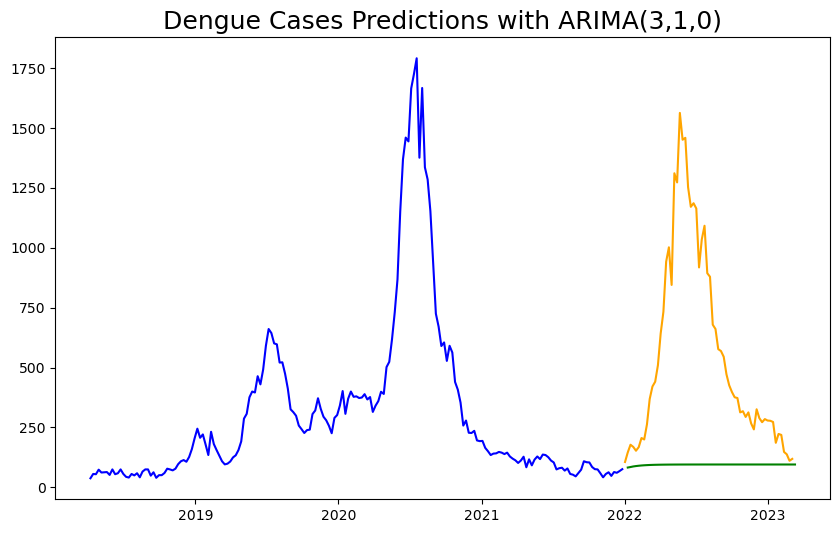

In [26]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data in blue.
plt.plot(train['dengue_cases'], color = 'blue')

# Plot testing data in orange.
plt.plot(test['dengue_cases'], color = 'orange')

# Plot predicted values in green.
plt.plot(preds, color = 'green')

plt.title(label = 'Dengue Cases Predictions with ARIMA(3,1,0)', fontsize=18)
plt.show();

In [27]:
# Evaluate the predictions MSE
mean_squared_error(test['dengue_cases'], preds)

371980.97119175445

In [28]:
# Evaluate the predictions with mean error
mean_squared_error(test['dengue_cases'], preds, squared=False)

609.9024275994927

In [29]:
# Evaluation of the model
error = round(mean_squared_error(test['dengue_cases'], preds, squared=True), 0)
print(f'Minimum Dengue Cases: {round(data["dengue_cases"].min(),0)}')
print(f'Maximum Dengue Cases: {round(data["dengue_cases"].max(),0)}')

print(f'MSE relative to minimum values in dengue cases: {round(error / data["dengue_cases"].min(),0)}.')
print(f'MSE relative to maximum values in dengue cases: {round(error / data["dengue_cases"].max(),0)}.')

Minimum Dengue Cases: 38
Maximum Dengue Cases: 1791
MSE relative to minimum values in dengue cases: 9789.0.
MSE relative to maximum values in dengue cases: 208.0.


Looking at the MSE values as well as the ratio of the mean squared error to the minimum and maximum values in the dengue cases, we can see that the model is not very good. 

#### Residual Plot

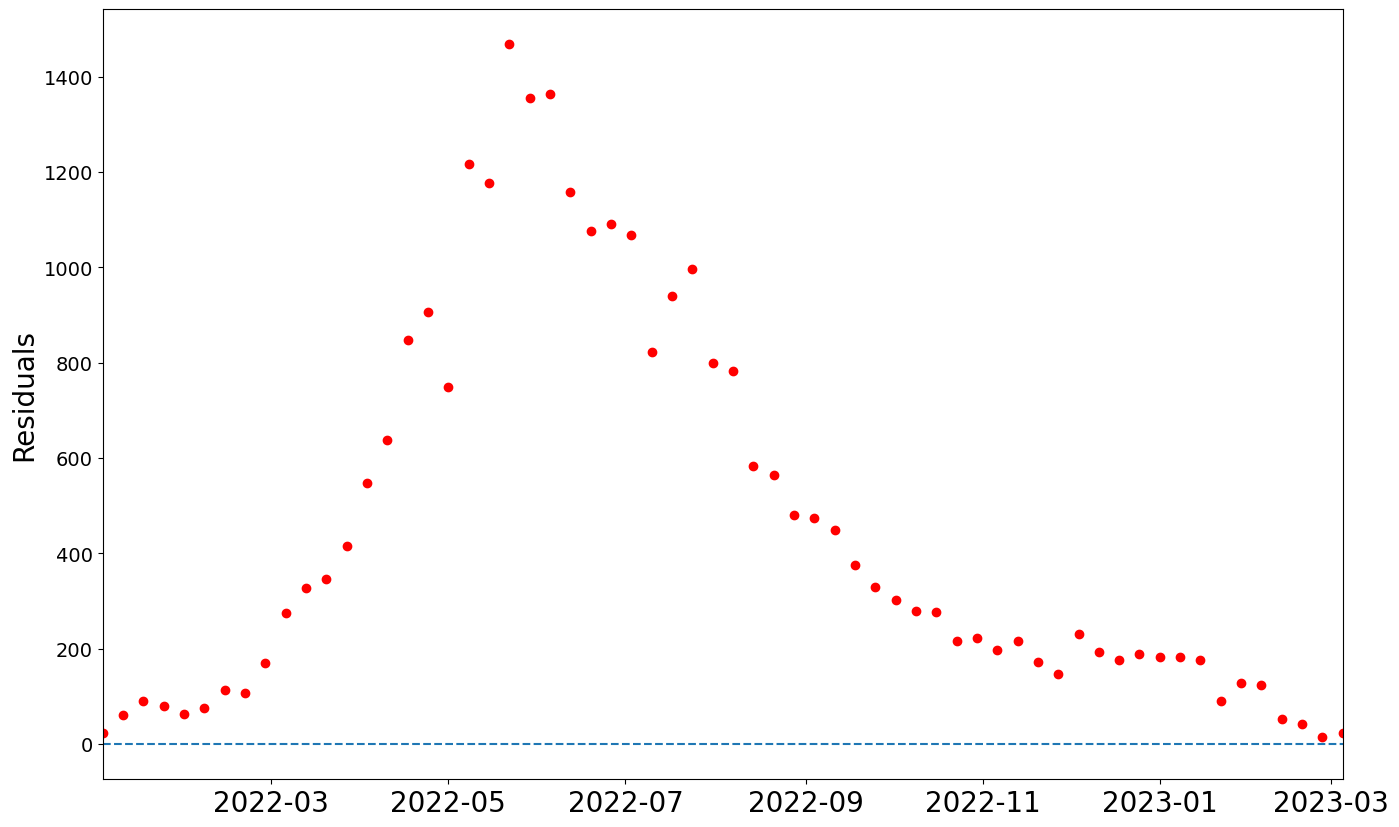

In [30]:
# Set figure size.
plt.figure(figsize=(16,10))

# Calculate residuals.
resids = test['dengue_cases'].values - preds.values

# Generate scatterplot of residuals.
plt.scatter(test['dengue_cases'].index, resids, c ='red')

# Plot baseline at y=0.
plt.hlines(y = 0,
           xmin = test['dengue_cases'].index.min(),
           xmax = test['dengue_cases'].index.max(),
           linestyles = '--')

# Set labels and axes.
plt.xticks(fontsize=20)
plt.xlim(test['dengue_cases'].index.min(), test['dengue_cases'].index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 20);

From the residual plot, we can see that the prediction is off to a high degree.

### ARIMAX Model

As we also have other features such as serology data, climate data and google trends, we can use an ARIMAX model to incorporate these features into the model. 

In [31]:
257-196 +1

62

In [32]:
# Instantiate best model.
arimax = ARIMA(endog=train['dengue_cases'], order=(3, 1, 0), 
               exog=train.drop(columns=['dengue_cases']))

# Fit ARIMA model.
model_2 = arimax.fit()

# Generate predictions based on test set.
#preds = model.predict(start=test.index[0], end = test.index[-1])
# Start at 196 instead of 195 because we took difference = 1
preds = model_2.predict(start=196, end=256, exog=test.drop(columns=['dengue_cases']))
# end should be 257, but it doesn't run unless i change it to 256 due to the shape of the exog

/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:574: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  is_monotonic = index.is_monotonic if date_index else None
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN

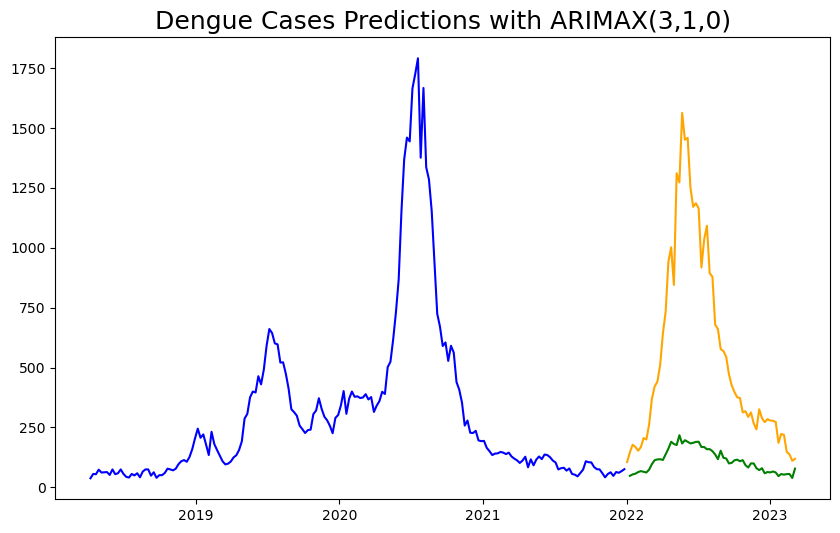

In [33]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data in blue.
plt.plot(train['dengue_cases'], color = 'blue')

# Plot testing data in orange.
plt.plot(test['dengue_cases'], color = 'orange')

# Plot predicted values in green.
plt.plot(preds, color = 'green')

plt.title(label = 'Dengue Cases Predictions with ARIMAX(3,1,0)', fontsize=18)
plt.show();

### Feature Engineering

We'll restart the whole data processsing here to engineer new features.

In [136]:
# Import the dataset
data2 = pd.read_csv("../datasets/merged_df2.csv")

In [137]:
data2.head()

,time,dengue_cases,denv_1,denv_2,denv_3,denv_4,Mean Temperature (°C),Mean Wind Speed (km/h),Daily Rainfall Total (mm),Maximum Temperature (°C),Max Wind Speed (km/h),Minimum Temperature (°C),google_trends
0,2018-04-08,38,0.000,0.505,0.484,0.011,28.528571,10.714286,0.742857,33.8,36.7,25.5,20
1,2018-04-15,56,0.000,0.505,0.484,0.011,28.914286,9.828571,2.057143,34.4,38.2,24.6,18
2,2018-04-22,55,0.000,0.505,0.484,0.011,28.142857,7.700000,0.371429,34.3,37.1,25.5,21
3,2018-04-29,74,0.000,0.505,0.484,0.011,28.414286,6.842857,4.800000,35.0,43.6,22.6,23
4,2018-05-06,62,0.029,0.549,0.382,0.039,28.785714,8.328571,3.742857,34.2,44.6,23.6,39


Feature engineering<br>
1. No need to engineer the serology numbers as they are just the percentage of the current cases
2. No need to engineer the google-trends data as people search as they get infected
3. Try 7 and 14 days lag for the climate data

In [138]:
lag_features = ['Mean Temperature (°C)', 'Mean Wind Speed (km/h)', 
               'Daily Rainfall Total (mm)', 'Maximum Temperature (°C)', 
               'Max Wind Speed (km/h)', 'Minimum Temperature (°C)']

window1 = 7
window2 = 14

In [139]:
for feature in lag_features:
    data2[f"{feature}_lag{window1}"] = data2[feature].shift(window1)
    data2[f"{feature}_lag{window2}"] = data2[feature].shift(window2)

In [140]:
data2.dropna(inplace=True)

In [141]:
data2['time'] = pd.to_datetime(data2['time'])
data2 = data2.set_index('time')

In [142]:
data2.shape

(243, 24)

In [143]:
0.8 * 243

194.4

In [144]:
train2 = data2.iloc[:194]
test2 = data2.iloc[194:]

In [145]:
train2.shape

(194, 24)

In [146]:
test2.shape

(49, 24)

In [147]:
train2.head()

,dengue_cases,denv_1,denv_2,denv_3,denv_4,Mean Temperature (°C),Mean Wind Speed (km/h),Daily Rainfall Total (mm),Maximum Temperature (°C),Max Wind Speed (km/h),Minimum Temperature (°C),google_trends,Mean Temperature (°C)_lag7,Mean Temperature (°C)_lag14,Mean Wind Speed (km/h)_lag7,Mean Wind Speed (km/h)_lag14,Daily Rainfall Total (mm)_lag7,Daily Rainfall Total (mm)_lag14,Maximum Temperature (°C)_lag7,Maximum Temperature (°C)_lag14,Max Wind Speed (km/h)_lag7,Max Wind Speed (km/h)_lag14,Minimum Temperature (°C)_lag7,Minimum Temperature (°C)_lag14
time,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-15,41,0.307,0.467,0.173,0.053,28.257143,10.285714,8.371429,32.3,51.1,21.9,22,28.314286,28.528571,6.914286,10.714286,6.914286,0.742857,33.1,33.8,49.3,36.7,24.0,25.5
2018-07-22,56,0.307,0.467,0.173,0.053,28.914286,11.514286,1.285714,31.9,40.0,23.5,23,27.842857,28.914286,5.600000,9.828571,17.371429,2.057143,32.9,34.4,45.0,38.2,22.9,24.6
2018-07-29,50,0.307,0.467,0.173,0.053,29.000000,12.400000,0.742857,33.0,41.0,24.9,25,29.728571,28.142857,9.557143,7.700000,0.600000,0.371429,33.4,34.3,36.4,37.1,24.2,25.5
2018-08-05,59,0.355,0.477,0.103,0.065,27.814286,10.028571,5.485714,32.4,40.3,24.0,21,29.100000,28.414286,9.328571,6.842857,1.685714,4.800000,33.1,35.0,42.5,43.6,23.6,22.6
2018-08-12,42,0.355,0.477,0.103,0.065,28.571429,10.342857,0.971429,33.0,40.0,21.9,17,27.742857,28.785714,8.271429,8.328571,4.628571,3.742857,32.2,34.2,47.2,44.6,23.6,23.6


In [148]:
exogenous_features = ['denv_1', 'denv_2', 'denv_3', 'denv_4', 
                     'Mean Temperature (°C)_lag7', 'Mean Temperature (°C)_lag14',
       'Mean Wind Speed (km/h)_lag7', 'Mean Wind Speed (km/h)_lag14',
       'Daily Rainfall Total (mm)_lag7', 'Daily Rainfall Total (mm)_lag14',
       'Maximum Temperature (°C)_lag7', 'Maximum Temperature (°C)_lag14',
       'Max Wind Speed (km/h)_lag7', 'Max Wind Speed (km/h)_lag14',
       'Minimum Temperature (°C)_lag7', 'Minimum Temperature (°C)_lag14', 'google_trends']

exogenous_features_7d = ['denv_1', 'denv_2', 'denv_3', 'denv_4', 
                     'Mean Temperature (°C)_lag7', 
       'Mean Wind Speed (km/h)_lag7', 
       'Daily Rainfall Total (mm)_lag7', 
       'Maximum Temperature (°C)_lag7', 
       'Max Wind Speed (km/h)_lag7', 
       'Minimum Temperature (°C)_lag7', 'google_trends']

exogenous_features_14d = ['denv_1', 'denv_2', 'denv_3', 'denv_4', 
                     'Mean Temperature (°C)_lag14', 
       'Mean Wind Speed (km/h)_lag14', 
       'Daily Rainfall Total (mm)_lag14', 
       'Maximum Temperature (°C)_lag14', 
       'Max Wind Speed (km/h)_lag14', 
       'Minimum Temperature (°C)_lag14', 'google_trends']

In [149]:
# Instantiate best model.
arimax = ARIMA(endog=train2['dengue_cases'], order=(3, 1, 0), 
               exog=train2[exogenous_features])

# Fit ARIMA model.
model_3 = arimax.fit()

# Generate predictions based on test set.
#preds = model.predict(start=test.index[0], end = test.index[-1])
# Start at 196 instead of 195 because we took difference = 1
preds3 = model_3.predict(start=194, end=242, exog=test2[exogenous_features])
# with exogenous_features, use start = 194 and end = 242

/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:574: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  is_monotonic = index.is_monotonic if date_index else None
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/Caskroom/miniconda/base/envs/dsi-sg/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN

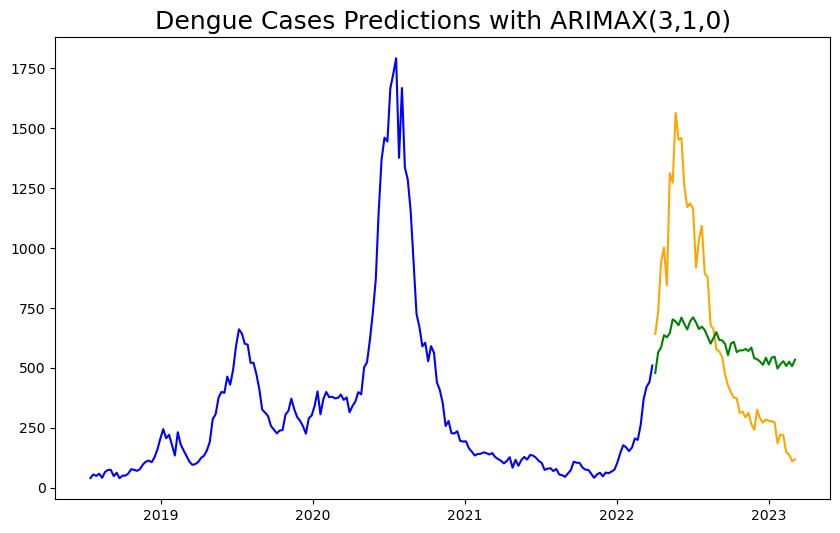

In [150]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data in blue.
plt.plot(train2['dengue_cases'], color = 'blue')

# Plot testing data in orange.
plt.plot(test2['dengue_cases'], color = 'orange')

# Plot predicted values in green.
plt.plot(preds3, color = 'green')

plt.title(label = 'Dengue Cases Predictions with ARIMAX(3,1,0)', fontsize=18)
plt.show();

### Auto ARIMA

In [151]:
# Install pmdarine at your own risk. It casues a lot of issues with the dependencies. 
from pmdarima.arima import auto_arima

ModuleNotFoundError: No module named 'pmdarima'

In [52]:
model_auto = auto_arima(train['dengue_cases'], exogenous=train.drop(columns=['dengue_cases']), 
                       trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2151.848, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2198.687, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2200.213, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2200.437, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2196.688, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2149.937, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2168.869, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2184.382, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2151.906, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2166.048, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2153.071, Time=0.16 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2150.737, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2147.939, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2166.871, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]          

In [70]:
# Instantiate best model.
arimax = ARIMA(endog=train['dengue_cases'], order=(1, 1, 2), 
               exog=train.drop(columns=['dengue_cases']))

# Fit ARIMA model.
model_2 = arimax.fit()

# Generate predictions based on test set.
#preds = model.predict(start=test.index[0], end = test.index[-1])
# Start at 196 instead of 195 because we took difference = 1
#preds = model.predict(start=196, end=257)
preds_auto = model_2.predict(start=196, end=256, exog=test.drop(columns=['dengue_cases']))

/usr/local/Caskroom/miniconda/base/envs/dsi-sg-test/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/Caskroom/miniconda/base/envs/dsi-sg-test/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/Caskroom/miniconda/base/envs/dsi-sg-test/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/Caskroom/miniconda/base/envs/dsi-sg-test/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


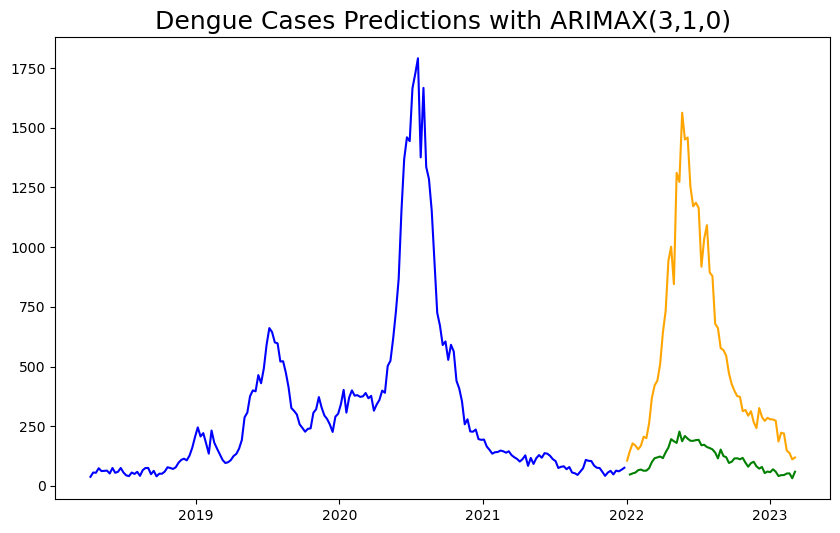

In [71]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data in blue.
plt.plot(train['dengue_cases'], color = 'blue')

# Plot testing data in orange.
plt.plot(test['dengue_cases'], color = 'orange')

# Plot predicted values in green.
plt.plot(preds_auto, color = 'green')

plt.title(label = 'Dengue Cases Predictions with ARIMAX(3,1,0)', fontsize=18)
plt.show();